In [21]:
import numpy as np
import time
import unittest
import import_ipynb
from mcts import Mcts
from node import Node
from template import Template
import random
import chess
from chess import svg
import datetime
from IPython.display import SVG
from IPython.display import clear_output

In [22]:
class Checkers(Template):
    def __init__(self):
        self.size = 8
        self.limit = 100
        self.turn = chess.BLACK
        self.resource = 10
        self.state = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/8/P1P1P1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        
    def getResource(self):
        return self.resource
    
    def isCellEmpty(self, i):
        return self.state.piece_at(i) is None
    
    def moves_limit(self):
        return self.limit
    
    def tempIsComplete(self,state):
        king = 1.2
        bk = 0
        bp = 0
        wk = 0
        wp = 0
        pieces = [state.piece_at(p) for p in state.piece_map().keys()]
        for piece in pieces:
            if piece.color is chess.WHITE:
                if piece.piece_type is chess.PAWN:
                    wp+=1
                else:
                    wk+=1
            else:
                if piece.piece_type is chess.PAWN:
                    bp+=1
                else:
                    bk+=1
        diff = wp + king*wk - bp - king*bk
        if diff>0:
            return 2
        elif diff<0:
            return 1
        else:
            return 0

    
    
    def changeTurn(self, turn):
        if turn is chess.WHITE:
            return chess.BLACK
        else:
            return chess.WHITE
    def printState(self,state):
        display(svg.board(board = state))
        
    def displayBoard(self):
        display(svg.board(board = self.state))
            
    def ifIsPositionWithinBoundary(self, x, y):
        return x>=0 and y>=0 and x<self.size and y<self.size
    
    def bottomRight(self, pos):
        x, y = pos//self.size-1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def bottomLeft(self, pos):
        x, y = pos//self.size-1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def topRight(self, pos):
        x, y = pos//self.size+1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
        
    def topLeft(self, pos):
        x, y = pos//self.size+1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None
    
    def pieceAtPosition(self,pos):
        return self.state.piece_at(pos)
        
    def validNeighbors(self,pos):
        tl = self.topLeft(pos)
        tr = self.topRight(pos)
        bl = self.bottomLeft(pos)
        br = self.bottomRight(pos)
        valid = []
        piece = self.pieceAtPosition(pos)
        if piece is None:
            raise Exception("Sorry, no piece present at position" + str(pos))
        
        if piece.piece_type == chess.PAWN and piece.color == chess.WHITE:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
                
        elif piece.piece_type == chess.PAWN and piece.color == chess.BLACK:
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        else:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        return valid
    
        
    def getOppColorPieces(self, neighbors, color):
        return [neighbor for neighbor in neighbors if self.pieceAtPosition(neighbor) is not None \
                               and self.pieceAtPosition(neighbor).color is not color]
    
    def validJumps(self, pos1, pos2):
        x1, y1 = pos1//self.size, pos1%self.size
        x2, y2 = pos2//self.size, pos2%self.size
        x, y = 2 *  x2 - x1, 2 * y2 - y1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) and self.isCellEmpty(x*self.size+y) else None
    
    def getFirstJumpsForPos(self, pos):
        jumps = []
        oppColorPositons = self.getOppColorPieces(self.validNeighbors(pos), self.state.piece_at(pos).color)
        for positions in oppColorPositons:
            if self.validJumps(pos,positions) is not None:
                jumps.append(self.validJumps(pos,positions))
        return jumps
    
    
    def makeAllCaptureMoves(self, i, options):
        stack = []
        for j in options:
            piece, isKing = self.makeMoveForRecursion(i,j)
            stack.append((piece, isKing))
            i = j
        return stack
    
    def getAllFirstJumps(self, turn):
        firstJumps = {}
        allPiecesPosition = [position for position in self.state.piece_map().keys() if self.state.piece_at(position).color == turn]
        for position in allPiecesPosition:
            firstJumpPos = self.getFirstJumpsForPos(position)
            if len(firstJumpPos) is not 0:
                firstJumps[position] = firstJumpPos
        return firstJumps
    

    def getCaptureMovesForPos(self, pos):
        paths = []
        
        testing = self.getFirstJumpsForPos(pos)

        for nextPos in testing:

          pieceRemoved, isConvertedToKing = self.makeMoveForRecursion(pos, nextPos)
          remainingPaths = self.getCaptureMovesForPos(nextPos)

          if not remainingPaths:
            paths.append([nextPos])

          else:
            for remainingPath in remainingPaths:
              paths.append([nextPos] + remainingPath)

          self.unMove(pos, nextPos, pieceRemoved, isConvertedToKing)
        
        return paths
    
    def makeMoveForRecursion(self, i, j):
        piece = self.state.remove_piece_at(i)
        self.state.set_piece_at(j, piece)
        isConverted = self.convertToKing(j)
        if self.isCaptureMove(i, j):
          return self.capturePiece(i, j), isConverted
        
        else:
          return None, isConverted


    def getAllCaptureMoves(self, turn):
      moves = {}
      allPiecesPosition = [position for position in self.state.piece_map().keys() if self.state.piece_at(position).color == turn]
      for position in allPiecesPosition:
          captureMoves = self.getCaptureMovesForPos(position)
          if captureMoves:
              moves[position] = captureMoves
      return moves
        


            
    def capturePiece(self, fromPos, toPos):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      return self.state.remove_piece_at(x * self.size + y)  
                
    def unCapturePiece(self, fromPos, toPos, piece):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      self.state.set_piece_at(x * self.size + y, piece)  


    
    def getRemainingMovesForPos(self, pos):
        return [positions for positions in self.validNeighbors(pos) if self.isCellEmpty(positions)]
    
    
    def getAllRemainingMoves(self, turn):
        moves = {}
        allPiecesPosition = [position for position in self.state.piece_map().keys() if self.state.piece_at(position).color == turn]
        for position in allPiecesPosition:
            moveForPos = self.getRemainingMovesForPos(position)
            if len(moveForPos) is not 0:
                moves[position] = moveForPos
        return moves
    
    def isValidMove(self, i, j):
        if self.isCellEmpty(i) or self.state.piece_at(i).color is not self.turn:
            return False
        
        moves = self.getAllFirstJumps(self.turn)
        
        if not moves:
            moves = self.getAllRemainingMoves(self.turn)
            
        return i in moves and j in moves[i]
            
    def isCaptureMove(self, i, j):
      return abs((j % self.size) - (i % self.size)) == 2
    
    def convertToKing(self, i):
        if self.state.piece_at(i).piece_type == chess.KING:
            return False
        
        if self.state.piece_at(i).color is chess.WHITE and i in range(56,64):
            self.state.set_piece_at(i, chess.Piece(chess.KING, chess.WHITE))
            return True
        if self.state.piece_at(i).color is chess.BLACK and i in range(0,8):
            self.state.set_piece_at(i, chess.Piece(chess.KING, chess.BLACK))
            return True
        
        return False
        
            
    
    def makeMove(self, i, j):
        if self.isValidMove(i, j):
            piece = self.state.remove_piece_at(i)
            self.state.set_piece_at(j, piece)
            isConverted = self.convertToKing(j)
        else:
            return None, None
            
        if self.isCaptureMove(i, j):
          return self.capturePiece(i, j), isConverted
        
        else:
          return None, isConverted
        
    def makeMoveWithoutCheck(self, i, j):
        if self.isCaptureMove(i, j):
            self.capturePiece(i, j)
        piece = self.state.remove_piece_at(i)
        self.state.set_piece_at(j, piece)
        self.convertToKing(j)
        
    def isGameComplete(self):
        if not self.getAllCaptureMoves(chess.WHITE) and not self.getAllRemainingMoves(chess.WHITE):
            return 1
        elif not self.getAllCaptureMoves(chess.BLACK) and not self.getAllRemainingMoves(chess.BLACK):
            return 2 
        return -1
    
    def isComplete(self, state):
#         board = self.getBoardFromState(state)
        tempBoard = self.state.copy()
        self.state = state.copy()
        if not self.getAllCaptureMoves(chess.WHITE) and not self.getAllRemainingMoves(chess.WHITE):
            self.state = tempBoard
            return 1
        elif not self.getAllCaptureMoves(chess.BLACK) and not self.getAllRemainingMoves(chess.BLACK):
            self.state = tempBoard
            return 2 
#         elif len(self.state.piece_map().keys())<10:
#             self.state = tempBoard
#             return 0
        self.state = tempBoard
        return -1


    def getAllMoves(self, turn):
        if self.getAllCaptureMoves(turn):
            return self.getAllCaptureMoves(turn)
        else:
            return self.getAllRemainingMoves(turn)
                    
    
    def getMoves(self, state, turn):
        tempBoard = self.state.copy()
        self.state = state.copy()
        moves = self.getAllMoves(turn)
        self.state = tempBoard
        extendmoves = []
        for i in moves.keys():
            for options in moves[i]:
                if isinstance(options,list):
                    m = [i]
                    m.extend(options)
                    extendmoves.append(m)
                else:
                    m = [i]
                    m.append(options)
                    extendmoves.append(m)
        np.random.shuffle(extendmoves)
        return extendmoves
    
    
    def executeMove(self,state,move,turn):
#         board = self.getBoardFromState(state)
        tempBoard = self.state.copy()
        self.state = state.copy()
        for i in range(len(move)-1):
            self.makeMoveWithoutCheck(move[i], move[i+1])
   
        state = self.state.copy()
        self.state = tempBoard
        
        return state
        
    def unMove(self, i, j, pieceToPlace, isConvertedToKing):
      piece = self.state.remove_piece_at(j)
      if isConvertedToKing:
        piece.piece_type = chess.PAWN
        
      self.state.set_piece_at(i, piece)

      if pieceToPlace is not None:
        self.unCapturePiece(i, j, pieceToPlace)
        
    def makeAllCaptureMoves(self, i, options):
        stack = []
        for j in options:
            piece, isKing = self.makeMoveForRecursion(i,j)
            stack.append((piece, isKing))
            i = j
        return stack
    
    def reverseAllCaptureMoves(self, i, options, stack):
        optionsCopy = options.copy()
        j = optionsCopy.pop()
        optionsCopy.insert(0,i)
        for i in reversed(optionsCopy):
            piece, isKing = stack.pop()
            self.unMove(i, j, piece, isKing)
            j = i
            
    def engine(self,debug = False):

      print("turn = ",self.turn)

      n = Node(self,turn= self.turn)
      n.state = self.state.copy()
      n.visited = 1
      n.isRoot = True # can be remobed
      n.isLeafNode = True


      mcts = Mcts(self,self.turn,n,debug = False)

      move =  mcts.execute(True)

      # del mcts
      assert move != None
      if debug:
          return mcts
      return move

    def heuristics2(self):
        king = 1.2
        bk = 0
        bp = 0
        wk = 0
        wp = 0
        pieces = [self.state.piece_at(p) for p in self.state.piece_map().keys()]
        for piece in pieces:
            if piece.color is self.turn:
                if piece.piece_type is chess.PAWN:
                    wp+=1
                else:
                    wk+=1
            else:
                if piece.piece_type is chess.PAWN:
                    bp+=1
                else:
                    bk+=1
        return wp + king*wk - bp - king*bk

    def minMax2(self, depth, isMaxPlayer, alpha, beta):
        if isMaxPlayer:
            turn = self.turn
        else:
            turn = self.changeTurn(self.turn)

        if depth>3:
            return {'position' : None, 'prize' : self.heuristics2()}

        finalState = self.isGameComplete()

        if finalState in [2,1]:
            if self.turn is chess.WHITE:
                if finalState == 2:
                    return {'position' : None, 'prize' : 100-depth}
                else:
                    return {'position' : None, 'prize' : -100+depth}
            else:
                if finalState == 1:
                    return {'position' : None, 'prize' : 100-depth}
                else:
                    return {'position' : None, 'prize' : -100+depth}

        if isMaxPlayer:
            best = -100
        else:
            best = 100

        moves = self.getAllMoves(turn)
        move_keys_list = list(moves.keys())
        random.shuffle(move_keys_list)
        for move in move_keys_list:
            for options in moves[move]:
                if isinstance(options,list):
                    stack = self.makeAllCaptureMoves(move, options)

                    recur = self.minMax2(depth+1,not isMaxPlayer, alpha, beta)

                    self.reverseAllCaptureMoves(move, options, stack)

                    if isMaxPlayer:
                        if recur['prize'] > best:
                            best = recur['prize']
                            nextMove = (move,options)
                            alpha = max(alpha,best)
                            if alpha>=beta:
                                break

                    else:
                        if recur['prize'] < best:
                            best = recur['prize']
                            nextMove = (move,options)
                            beta = min(beta,best)
                            if alpha>=beta:
                                break

                else:
                    piece, isKing = self.makeMoveForRecursion(move,options)
                    recur = self.minMax2(depth+1,not isMaxPlayer, alpha, beta)
                    self.unMove(move, options, piece, isKing)

                    if isMaxPlayer:
                        if recur['prize'] > best:
                            best = recur['prize']
                            nextMove = (move,[options])
                            alpha = max(alpha,best)
                            if alpha>=beta:
                                break

                    else:
                        if recur['prize'] < best:
                            best = recur['prize']
                            nextMove = (move,[options])
                            beta = min(beta,best)
                            if alpha>=beta:
                                break

        return {'position': nextMove, 'prize': best}

    def play(self,youFirst = True):
        print("\t Checkers \n Bot = Black \n You = White ")
        while True:
          clear_output(True)
          res = self.isGameComplete()
          if res in [2,1]:
            if res == 2:
              print("WHITE Wins")
              self.displayBoard()
            elif res == 1:
              print("BLACK Wins")
              self.displayBoard()
            break
            
          if self.turn == chess.WHITE:
            print("White's Turn") 
          else:
            print("Black's Turn")
          self.displayBoard()
          
          if res == -1:  
              if self.turn == chess.BLACK:
                move = self.engine()
                self.state = self.executeMove(self.state,move,self.turn)
    #             i = int(input("Enter Start Location"))-1
    #             j = int(input("Enter End Location"))-1

    #             if not self.isValidMove(i,j):
    #               print("Invalid Input! Please enter another number ")
    #               continue

    #             piece, _ = self.makeMove(i,j)

    #             if piece is not None:
    #               leftMoves = self.getCaptureMovesForPos(j)
    #               if leftMoves:
    #                 print("Continue to Capture")
    #                 continue


              else:
                print("Bots Turn")
                d = self.minMax2(0,True, -2000, 2000)
                i,move = d['position']
            
                for j in move:
                  self.makeMoveForRecursion(i,j)
                  i = j
#                 move = self.engine()
#                 self.state = self.executeMove(self.state,move,self.turn)

              self.turn = self.changeTurn(self.turn)    

          
    
    
          clear_output(True)
          

#     def minimax()
        

WHITE Wins


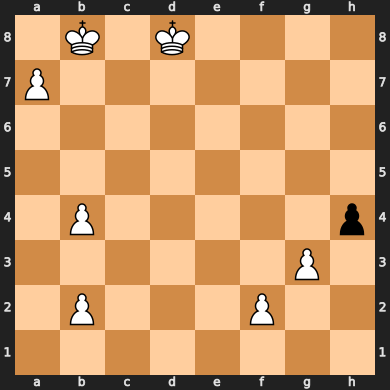

In [23]:
checkers = Checkers()
# moves = checkers.getMoves(chess.Board("1p1p1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4"), True)
# checkers.executeMove(chess.Board("1p1p1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4"), moves[0], True)
checkers.play()

In [8]:
chess.BLACK

False